In [ ]:
import nltk
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud 
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score

from yellowbrick.classifier import PrecisionRecallCurve


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Figure&Display options
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
root = "/gdrive/MyDrive/5293_Project_2/"
outputs_dir = root + "output"

# 1. EDA

In [ ]:
#df = pd.read_csv(io.StringIO(uploaded['Womens Clothing E-Commerce Reviews.csv'].decode('utf-8')))
df = pd.read_csv(root + 'data/train.csv')

In [ ]:
#df = pd.read_csv(root + 'data/train.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
#!pip install -U pandas-profiling --user
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

'''
from pandas_profiling import ProfileReport
from pandas_profiling.report.presentation.flavours.html.templates import create_html_assets

df.profile_report()
'''

'\nfrom pandas_profiling import ProfileReport\nfrom pandas_profiling.report.presentation.flavours.html.templates import create_html_assets\n\ndf.profile_report()\n'

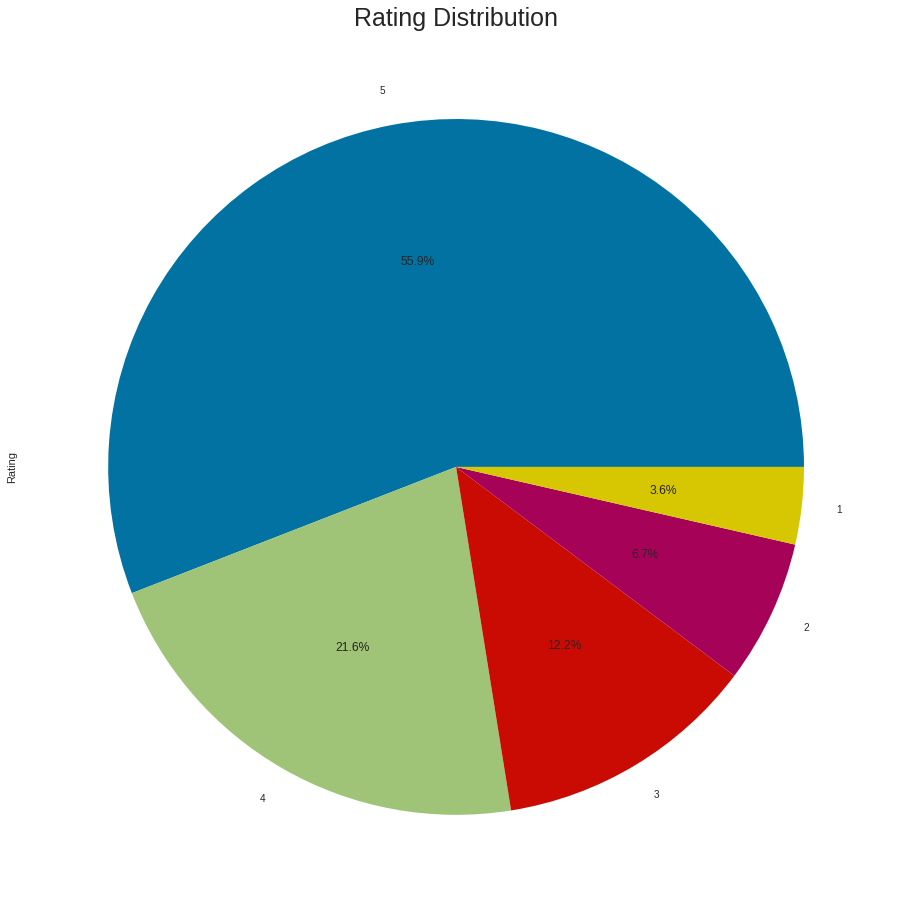

In [ ]:
df["Rating"].describe().T
plt.title('Rating Distribution', fontsize=25)
df["Rating"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(16, 16));




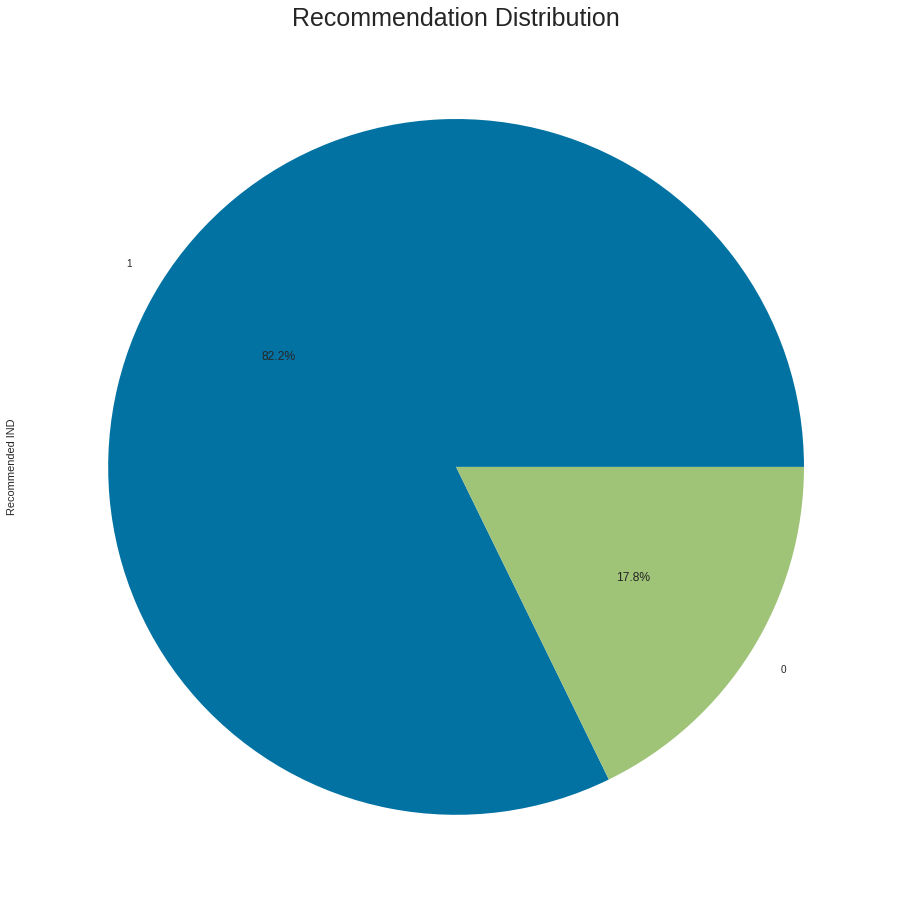

In [ ]:
df["Recommended IND"].describe().T
plt.title('Recommendation Distribution', fontsize=25)
df["Recommended IND"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(16, 16));

In [ ]:
FreqOfWords = df['Review Text'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0, width=1000, height=600)
fig = fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (Before Cleaning)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig = fig.update_traces(textinfo="label+value")
fig.show()

# 2. Data Processing

## 2.1 Featuer selection

In [ ]:
df.columns


Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [ ]:
#only keeping rating 
df.drop(['Unnamed: 0','Clothing ID', 'Age', 'Title', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'], axis=1, inplace=True)
df.head(5)

,Review Text,Rating,Recommended IND
0,Absolutely wonderful - silky and sexy and comf...,4,1
1,Love this dress! it's sooo pretty. i happene...,5,1
2,I had such high hopes for this dress and reall...,3,0
3,"I love, love, love this jumpsuit. it's fun, fl...",5,1
4,This shirt is very flattering to all due to th...,5,1


In [ ]:
for i in (0,3,11,13): 
  print(i+1,". ", df['Review Text'].values[i])
  print()

1 .  Absolutely wonderful - silky and sexy and comfortable

4 .  I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!

12 .  This dress is perfection! so pretty and flattering.

14 .  Bought the black xs to go under the larkspur midi dress because they didn't bother lining the skirt portion (grrrrrrrrrrr).
my stats are 34a-28/29-36 and the xs fit very smoothly around the chest and was flowy around my lower half, so i would say it's running big.
the straps are very pretty and it could easily be nightwear too.
i'm 5'6" and it came to just below my knees.



## 2.2 Missing values

In [ ]:
print(df['Review Text'].isnull().value_counts())
print('---------------------------------------')
print(df['Rating'].isnull().value_counts())

False    22641
True       845
Name: Review Text, dtype: int64
---------------------------------------
False    23486
Name: Rating, dtype: int64


In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review Text      22641 non-null  object
 1   Rating           22641 non-null  int64 
 2   Recommended IND  22641 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 707.5+ KB


# 3. Text Mining

## 3.1 Tokenization and Noise Removal

In [ ]:
def text_cleaning(data):
    
    import re
    #1. Remove Puncs
    # \w typically matches [A-Za-z0-9_]
    text = re.sub('[^\w\s]','', data)
         
    #2. Tokenize
    text_tokens = word_tokenize(text.lower()) 
    
    #3. Remove numbers
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #5. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    #joining
    return " ".join(text_cleaned)

In [ ]:
stop_words = stopwords.words('english')

df["Review Text"] = df["Review Text"].apply(text_cleaning)
df.head(5)

,Review Text,Rating,Recommended IND
0,absolutely wonderful silky sexy comfortable,4,1
1,love dress sooo pretty happened find store im ...,5,1
2,high hope dress really wanted work initially o...,3,0
3,love love love jumpsuit fun flirty fabulous ev...,5,1
4,shirt flattering due adjustable front tie perf...,5,1


## 3.2 Handling Rare Words 

In [ ]:
#find all words frequency
word_values = pd.Series(" ".join(df["Review Text"]).split()).value_counts()
word_values

dress       11319
fit         10091
size         9349
love         8968
top          8256
            ...  
takeout         1
teenybop        1
hugely          1
shirred         1
platinum        1
Length: 16758, dtype: int64

In [ ]:
#define rare words as the words appeared less or equal to 2 times
rare_words = word_values[word_values <= 2]
rare_words.value_counts()

1    9058
2    1877
dtype: int64

In [ ]:
df["Review Text"] = df["Review Text"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))
df.head(5)

,Review Text,Rating,Recommended IND
0,absolutely wonderful silky sexy comfortable,4,1
1,love dress sooo pretty happened find store im ...,5,1
2,high hope dress really wanted work initially o...,3,0
3,love love love jumpsuit fun flirty fabulous ev...,5,1
4,shirt flattering due adjustable front tie perf...,5,1


In [ ]:
for i in (0,3,11,13): 
  print(i+1,". ", df['Review Text'].values[i])
  print()

1 .  absolutely wonderful silky sexy comfortable

4 .  love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment

12 .  dress perfection pretty flattering

14 .  bought black x go midi dress didnt bother lining skirt portion stats x fit smoothly around chest flowy around lower half would say running big strap pretty could easily im came knee



# 4. Wordcloud

In [ ]:
FreqOfWords = df['Review Text'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0, width=1000, height=600)
fig = fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (After Cleaning)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig = fig.update_traces(textinfo="label+value")
fig.show()

In [ ]:
review_text = df["Review Text"]
all_words = " ".join(review_text)
print(all_words[:199])

absolutely wonderful silky sexy comfortable love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true 


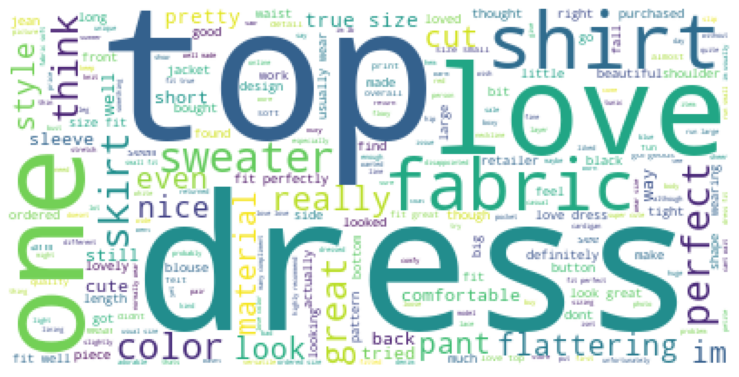

In [ ]:
from wordcloud import WordCloud 

wordcloud = WordCloud(background_color="white", max_words =250).generate(all_words)

plt.figure(figsize = (13, 13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 4.2 Split by ratings

In [ ]:
df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
df.head(5)

,review_text,rating,recommended_ind
0,absolutely wonderful silky sexy comfortable,4,1
1,love dress sooo pretty happened find store im ...,5,1
2,high hope dress really wanted work initially o...,3,0
3,love love love jumpsuit fun flirty fabulous ev...,5,1
4,shirt flattering due adjustable front tie perf...,5,1


In [ ]:
" ".join(df["review_text"]).split()
rate_1 = " ".join(df[df["rating"] == 1].review_text).split()
rate_2 = " ".join(df[df["rating"] == 2].review_text).split()
rate_3 = " ".join(df[df["rating"] == 3].review_text).split()
rate_4 = " ".join(df[df["rating"] == 4].review_text).split()
rate_5 = " ".join(df[df["rating"] == 5].review_text).split()
print(rate_1)

['tag', 'sewn', 'small', 'long', 'huge', 'x', 'itchy', 'cut', 'thread', 'left', 'behind', 'plasticy', 'even', 'itchy', 'make', 'item', 'itchy', 'tag', 'comfortable', 'also', 'love', 'bralettes', 'wear', 'time', 'including', 'work', 'b', 'cup', 'however', 'one', 'thin', 'flimsy', 'give', 'support', 'even', 'b', 'cup', 'would', 'lounging', 'bralette', 'wasnt', 'itchy', 'really', 'hoping', 'like', 'look', 'way', 'model', 'least', 'hem', 'much', 'pronounced', 'looser', 'one', 'photo', 'look', 'like', 'pinned', 'back', 'usually', 'wear', 'medium', 'large', 'got', 'medium', 'lot', 'material', 'bottom', 'half', 'photo', 'show', 'made', 'look', 'bigger', 'flattering', 'material', 'nice', 'weave', 'thin', 'delicate', 'bought', 'holly', 'deep', 'olive', 'blue', 'color', 'usually', 'wear', 'medium', 'bought', 'small', 'fit', 'ok', 'shape', 'flattering', 'love', 'baby', 'doll', 'dress', 'top', 'tent', 'daughter', 'saw', 'try', 'said', 'thats', 'piece', 'tablecloth', 'going', 'back', 'excited', 'or

## 5. Vectorization

## Train and Test Set & Split BY RATING

In [ ]:
from sklearn.model_selection import train_test_split
X = df["review_text"]
y1 = df["rating"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, stratify=y1, random_state=123)

## 5.1 Vectorization

### 5.1(a) Count Vectorization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)


In [ ]:
pd.DataFrame(X_train_count.toarray(), columns = vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aa,ab,abby,abdomen,ability,able,abo,abovetheknee,absolute,absolutely,...,zero,zig,zigzag,zip,zipped,zipper,zippered,zipping,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
18109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5.1(b) TF-IDF Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vectorizer = TfidfVectorizer()

X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [ ]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aa,ab,abby,abdomen,ability,able,abo,abovetheknee,absolute,absolutely,...,zero,zig,zigzag,zip,zipped,zipper,zippered,zipping,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
18108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.176044,0.131495,0.0,0.0,0.0,0.0
18109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
18110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


# Td-idf / Count Analysis

## Train and Test Set & Split BY REC(0/1)

In [ ]:
from sklearn.model_selection import train_test_split
X = df["review_text"]
y2 = df["recommended_ind"]
X_train_rec, X_test_rec, y_train_rec, y_test_rec = train_test_split(X, y2, test_size=0.2, stratify=y2, random_state=123)

In [ ]:
X_train_count = vectorizer.fit_transform(X_train_rec)
X_test_count = vectorizer.transform(X_test_rec)

In [ ]:
pd.DataFrame(X_train_count.toarray(), columns = vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aa,ab,abby,abdomen,ability,able,abo,abovetheknee,absolute,absolutely,...,zero,zig,zigzag,zip,zipped,zipper,zippered,zipping,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train_rec)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test_rec)

In [ ]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aa,ab,abby,abdomen,ability,able,abo,abovetheknee,absolute,absolutely,...,zero,zig,zigzag,zip,zipped,zipper,zippered,zipping,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.138365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# tfidf analysis

##Rating

In [ ]:
from sklearn.model_selection import train_test_split
X = df["review_text"]
y1 = df["rating"]
y1

0        4
1        5
2        3
3        5
4        5
        ..
23481    5
23482    3
23483    3
23484    3
23485    5
Name: rating, Length: 22641, dtype: int64

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y1, test_size=0.2, stratify=y1, random_state=123)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

In [ ]:
#lr
pipe_lr = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, min_df = 5)),
                    ('lr', LogisticRegression(penalty = 'l1', 
                                              solver = 'liblinear', 
                                              random_state = 123))])

params = {'tfidf__ngram_range':[(1,1), (1,2), (2,2)],
          'lr__C':[0.1,1,10,100]}
gscv = GridSearchCV(pipe_lr, params, cv = 3, n_jobs = -1).fit(X_train_r, y_train_r)

In [ ]:
gscv.best_params_

{'lr__C': 1, 'tfidf__ngram_range': (1, 2)}

In [ ]:
gscv.score(X_test_r, y_test_r)

0.6288363877235593

In [ ]:
pipe_lr_best1 = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, ngram_range = (1,2), min_df = 5)),
                    ('lr', LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1, random_state = 123))])
pipe_lr_best1.fit(X_train_r, y_train_r)
print(pipe_lr_best1.score(X_train_r, y_train_r))
print(pipe_lr_best1.score(X_test_r, y_test_r))

0.6713780918727915
0.6288363877235593


In [ ]:
not_match = pd.DataFrame(X_test_r[pipe_lr_best1.predict(X_test_r) != y_test_r]).join(pd.DataFrame(y_test_r[pipe_lr_best1.predict(X_test_r) != y_test_r]))
not_match.rating.value_counts()

4    725
3    386
2    266
5    159
1    145
Name: rating, dtype: int64

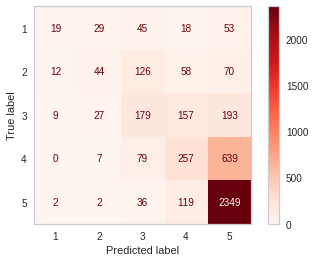

In [ ]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
#https://www.tutorialspoint.com/how-to-hide-axes-and-gridlines-in-matplotlib
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_r, pipe_lr_best1.predict(X_test_r))
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','2','3','4','5'])
cmd.plot(cmap = "Reds");
plt.grid(False)
#good at predict the reviews that give a five star rating
#but tends to predict reviews with rating other than 5 to a higher rating

In [ ]:
#gbc
pipe_gbc = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, min_df = 5)),
                    ('gbc', GradientBoostingClassifier(random_state = 123))])

params = {'tfidf__ngram_range':[(1,1), (1,2), (2,2)],
          'gbc__learning_rate':[0.1,0.2,0.3]}
gscv = GridSearchCV(pipe_gbc, params, cv = 3, n_jobs = -1).fit(X_train_r, y_train_r)

In [ ]:
gscv.best_params_

{'gbc__learning_rate': 0.2, 'tfidf__ngram_range': (1, 2)}

In [ ]:
gscv.score(X_test_r, y_test_r)

0.6038860675645837

In [ ]:
pipe_gbc_best1 = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, ngram_range = (1,2), min_df = 5)),
                    ('gbc', GradientBoostingClassifier(learning_rate = 0.2, random_state = 123))])
pipe_gbc_best1.fit(X_train_r, y_train_r)
print(pipe_gbc_best1.score(X_train_r, y_train_r))
print(pipe_gbc_best1.score(X_test_r, y_test_r))

0.7418286219081273
0.6038860675645837


In [ ]:
not_match = pd.DataFrame(X_test_r[pipe_gbc_best1.predict(X_test_r) != y_test_r]).join(pd.DataFrame(y_test_r[pipe_gbc_best1.predict(X_test_r) != y_test_r]))
not_match.rating.value_counts()

4    767
3    445
2    266
5    169
1    147
Name: rating, dtype: int64

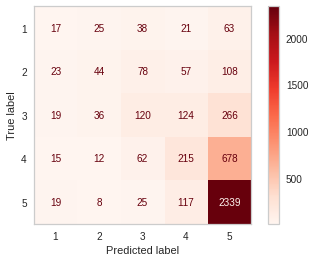

In [ ]:
cm = confusion_matrix(y_test_r, pipe_gbc_best1.predict(X_test_r))
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','2','3','4','5'])
cmd.plot(cmap = "Reds");
plt.grid(False)
#good at predict the reviews that give a five star rating
#but tends to predict reviews with rating other than 5 to a higher rating
#tend to predict all rating to 5

In [ ]:
from sklearn.ensemble import RandomForestClassifier
pipe_rfc = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, min_df = 5)),
                    ('rfc', RandomForestClassifier(random_state = 123))])

params = {'tfidf__ngram_range':[(1,1), (1,2), (2,2)],
          'rfc__max_depth':[10,20,30,40,50,60,70,80,90,100]}
gscv = GridSearchCV(pipe_rfc, params, cv = 3, n_jobs = -1).fit(X_train_r, y_train_r)

In [ ]:
gscv.best_params_

{'rfc__max_depth': 90, 'tfidf__ngram_range': (1, 1)}

In [ ]:
gscv.score(X_test_r, y_test_r)

0.5815853389269154

In [ ]:
pipe_rfc_best1 = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, ngram_range = (1,1), min_df = 5)),
                    ('rfc', RandomForestClassifier(max_depth = 90,random_state = 123))])
pipe_rfc_best1.fit(X_train_r, y_train_r)
print(pipe_rfc_best1.score(X_train_r, y_train_r))
print(pipe_rfc_best1.score(X_test_r, y_test_r))

0.9898962014134276
0.5815853389269154


In [ ]:
not_match = pd.DataFrame(X_test_r[pipe_rfc_best1.predict(X_test_r) != y_test_r]).join(pd.DataFrame(y_test_r[pipe_rfc_best1.predict(X_test_r) != y_test_r]))
not_match.rating.value_counts()

4    925
3    470
2    302
1    161
5     37
Name: rating, dtype: int64

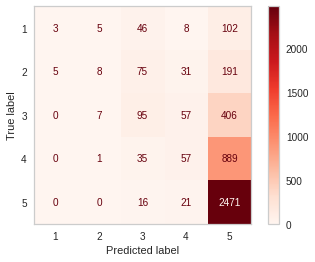

In [ ]:
cm = confusion_matrix(y_test_r, pipe_rfc_best1.predict(X_test_r))
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','2','3','4','5'])
cmd.plot(cmap = "Reds");
plt.grid(False)
#good at predict the reviews that give a five star rating
#but tends to predict reviews with rating other than 5 to a higher rating
#tend to predict all rating to 5

In [ ]:
# for random forest classifier, a little bit overfitting
# So I change to (1,2) and search for the parameters
pipe_rfc = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, min_df = 5, ngram_range = (1,2))),
                    ('rfc', RandomForestClassifier(random_state = 123))])

params = {'rfc__max_depth':[10,20,30,40,50,60,70,80,90,100]}
gscv = GridSearchCV(pipe_rfc, params, cv = 3, n_jobs = -1).fit(X_train_r, y_train_r)

In [ ]:
gscv.best_params_

{'rfc__max_depth': 100}

In [ ]:
gscv.score(X_test_r, y_test_r)

In [ ]:
pipe_rfc_best1_2 = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, ngram_range = (1,2), min_df = 5)),
                    ('rfc', RandomForestClassifier(max_depth = 100,random_state = 123))])
pipe_rfc_best1_2.fit(X_train_r, y_train_r)
print(pipe_rfc_best1_2.score(X_train_r, y_train_r))
print(pipe_rfc_best1_2.score(X_test_r, y_test_r))
#not help much

0.9763692579505301
0.5784941488187237


In [ ]:
not_match = pd.DataFrame(X_test_r[pipe_rfc_best1_2.predict(X_test_r) != y_test_r]).join(pd.DataFrame(y_test_r[pipe_rfc_best1_2.predict(X_test_r) != y_test_r]))
not_match.rating.value_counts()

4    950
3    487
2    298
1    161
5     13
Name: rating, dtype: int64

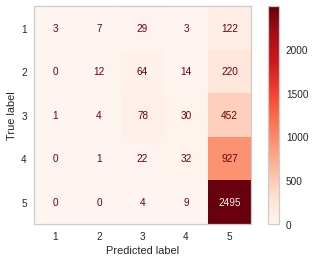

In [ ]:
cm = confusion_matrix(y_test_r, pipe_rfc_best1_2.predict(X_test_r))
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','2','3','4','5'])
cmd.plot(cmap = "Reds");
plt.grid(False)
#good at predict the reviews that give a five star rating
#but tends to predict reviews with rating other than 5 to a higher rating
#tend to predict all rating to 5

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
tfidf = TfidfVectorizer(max_df=.8, ngram_range = (1,2), min_df = 5)
X_tfidf = tfidf.fit_transform(df["review_text"])
lda = LatentDirichletAllocation(n_components=5, n_jobs = -1, random_state=123)
X_lda = lda.fit_transform(X_tfidf)
vocab = tfidf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
vocab = [items.replace(' ', '_') for items in vocab]

In [ ]:
vocab = np.array(vocab)

In [ ]:
for ind in range(lda.components_.shape[0]):
    index = np.argsort(lda.components_[ind])[::-1][:20]
    terms = vocab[index]
    terms = ' '.join(terms)
    print(f'Topic #{ind:2d} : {terms}')
# five topics are expected to match five ratings, but you can see that the words here in each topic contain more positive words than negative words.
# I think that is why the algrithm gets confused.

Topic # 0 : size dress fit top love im wear small great color ordered would run perfect petite large like flattering cute one
Topic # 1 : dress look love color like beautiful great fit make cant fabric good picture comfy loved looked back even top boxy
Topic # 2 : dress top look fabric like love fit color size wear would much great flattering im really nice skirt little one
Topic # 3 : like sweater size fit small color im look would top wear love ordered dress really large medium shirt one back
Topic # 4 : great love jean comfortable fit perfect pant soft super wear dress color pair cute look flattering compliment size top comfy


##Recommend 

In [ ]:
from sklearn.model_selection import train_test_split
X = df["review_text"]
y2 = df["recommended_ind"]
X_train_rec, X_test_rec, y_train_rec, y_test_rec = train_test_split(X, y2, test_size=0.2, stratify=y2, random_state=123)

In [ ]:
pipe_lr = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, min_df = 5)),
                    ('lr', LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state = 123))])

params = {'tfidf__ngram_range':[(1,1), (1,2), (2,2)],
          'lr__C':[0.1,1,10,100]}
gscv = GridSearchCV(pipe_lr, params, cv = 3, n_jobs = -1).fit(X_train_rec, y_train_rec)

In [ ]:
gscv.best_params_

{'lr__C': 1, 'tfidf__ngram_range': (1, 2)}

In [ ]:
gscv.score(X_test_rec, y_test_rec)

0.8834179730624862

In [ ]:
pipe_lr_best2 = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, ngram_range = (1,2), min_df = 5)),
                    ('lr', LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1, random_state = 123))])
pipe_lr_best2.fit(X_train_rec, y_train_rec)
print(pipe_lr_best2.score(X_train_rec, y_train_rec))
print(pipe_lr_best2.score(X_test_rec, y_test_rec))
#better at predicting recommend or not than rating

0.9032685512367491
0.8834179730624862


In [ ]:
not_match = pd.DataFrame(X_test_rec[pipe_lr_best2.predict(X_test_rec) != y_test_rec]).join(pd.DataFrame(y_test_rec[pipe_lr_best2.predict(X_test_rec) != y_test_rec]))
not_match.recommended_ind.value_counts()
# tend to predict the review with "not recommended" as "recommended"

0    379
1    149
Name: recommended_ind, dtype: int64

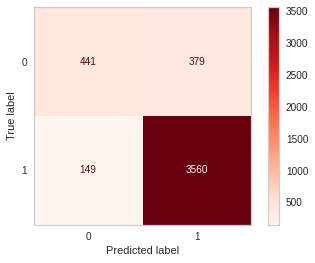

In [ ]:
cm = confusion_matrix(y_test_rec, pipe_lr_best2.predict(X_test_rec))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap = "Reds");
plt.grid(False)
#good at predicting recommended, but not good at predicting not recommended. 

In [ ]:
#gbc
pipe_gbc = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, min_df = 5)),
                    ('gbc', GradientBoostingClassifier(random_state = 123))])

params = {'tfidf__ngram_range':[(1,1), (1,2), (2,2)],
          'gbc__learning_rate':[0.1,0.2,0.3, 0.4, 0.5]}
gscv = GridSearchCV(pipe_gbc, params, cv = 3, n_jobs = -1).fit(X_train_rec, y_train_rec)

In [ ]:
gscv.best_params_

{'gbc__learning_rate': 0.3, 'tfidf__ngram_range': (1, 2)}

In [ ]:
gscv.score(X_test_rec, y_test_rec)

0.8699492161625083

In [ ]:
pipe_gbc_best2 = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, ngram_range = (1,2), min_df = 5)),
                    ('gbc', GradientBoostingClassifier(learning_rate = 0.3, random_state = 123))])
pipe_gbc_best2.fit(X_train_rec, y_train_rec)
print(pipe_gbc_best2.score(X_train_rec, y_train_rec))
print(pipe_gbc_best2.score(X_test_rec, y_test_rec))

0.9165746466431095
0.8699492161625083


In [ ]:
not_match = pd.DataFrame(X_test_rec[pipe_gbc_best2.predict(X_test_rec) != y_test_rec]).join(pd.DataFrame(y_test_rec[pipe_gbc_best2.predict(X_test_rec) != y_test_rec]))
not_match.recommended_ind.value_counts()
#tend to predict the review with "not recommended" as "recommended"

0    478
1    111
Name: recommended_ind, dtype: int64

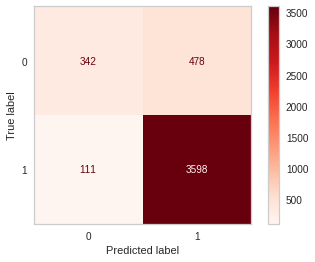

In [ ]:
cm = confusion_matrix(y_test_rec, pipe_gbc_best2.predict(X_test_rec))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap = "Reds");
plt.grid(False)
#good at predicting recommended, but not good at predicting not recommended. 

In [ ]:
#rfc
from sklearn.ensemble import RandomForestClassifier
pipe_rfc = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, min_df = 5)),
                    ('rfc', RandomForestClassifier(random_state = 123))])

params = {'tfidf__ngram_range':[(1,1), (1,2), (2,2)],
          'rfc__max_depth':[10,20,30,40,50,60,70,80,90,100]}
gscv = GridSearchCV(pipe_rfc, params, cv = 3, n_jobs = -1).fit(X_train_rec, y_train_rec)

In [ ]:
gscv.best_params_

{'rfc__max_depth': 90, 'tfidf__ngram_range': (1, 2)}

In [ ]:
gscv.score(X_test_rec, y_test_rec)

0.8487524839920513

In [ ]:
pipe_rfc_best2 = Pipeline([('tfidf',TfidfVectorizer(max_df=.8, ngram_range = (1,2), min_df = 5)),
                    ('rfc', RandomForestClassifier(max_depth = 90,random_state = 123))])
pipe_rfc_best2.fit(X_train_rec, y_train_rec)
print(pipe_rfc_best2.score(X_train_rec, y_train_rec))
print(pipe_rfc_best2.score(X_test_rec, y_test_rec))

0.9764244699646644
0.8487524839920513


In [ ]:
not_match = pd.DataFrame(X_test_rec[pipe_rfc_best2.predict(X_test_rec) != y_test_rec]).join(pd.DataFrame(y_test_rec[pipe_rfc_best2.predict(X_test_rec) != y_test_rec]))
not_match.recommended_ind.value_counts()
#tend to predict the review with "not recommended" as "recommended"

0    657
1     28
Name: recommended_ind, dtype: int64

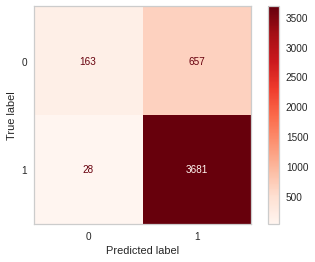

In [ ]:
cm = confusion_matrix(y_test_rec, pipe_rfc_best2.predict(X_test_rec))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap = "Reds");
plt.grid(False)
#good at predicting recommended, but not good at predicting not recommended. 
#compared to previous model, tend to predict not rec to rec more.

In [ ]:
tfidf = TfidfVectorizer(max_df=.8, ngram_range = (1,2), min_df = 5)
X_tfidf = tfidf.fit_transform(df["review_text"])
lda = LatentDirichletAllocation(n_components=2, n_jobs = -1, random_state=123) #two topics
X_lda = lda.fit_transform(X_tfidf)
vocab = tfidf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
vocab = [items.replace(' ', '_') for items in vocab]

In [ ]:
vocab = np.array(vocab)

In [ ]:
for ind in range(lda.components_.shape[0]):
    index = np.argsort(lda.components_[ind])[::-1][:20]
    terms = vocab[index]
    terms = ' '.join(terms)
    print(f'Topic #{ind:2d} : {terms}')
# more positive words than negative words, that is why we tend to predict not rec as rec

Topic # 0 : size top fit love small im wear great dress run ordered little large cute shirt color medium bought perfect would
Topic # 1 : dress look like sweater color love great fabric beautiful really would much back fit make wear soft feel material work


In [ ]:
import matplotlib.pyplot as plt
df_yvalues = pd.DataFrame(y1).join(pd.DataFrame(y2))
df_yvalues
Class = ["1", "2", "3", "4", "5"]
recommend = [df_yvalues.loc[(df_yvalues.recommended_ind == 1)&(df_yvalues.rating == 1),:].shape[0], 
             df_yvalues.loc[(df_yvalues.recommended_ind == 1)&(df_yvalues.rating == 2),:].shape[0],
             df_yvalues.loc[(df_yvalues.recommended_ind == 1)&(df_yvalues.rating == 3),:].shape[0],
             df_yvalues.loc[(df_yvalues.recommended_ind == 1)&(df_yvalues.rating == 4),:].shape[0],
             df_yvalues.loc[(df_yvalues.recommended_ind == 1)&(df_yvalues.rating == 5),:].shape[0]
             ]
not_recommend = [df_yvalues.loc[(df_yvalues.recommended_ind == 0)&(df_yvalues.rating == 1),:].shape[0], 
             df_yvalues.loc[(df_yvalues.recommended_ind == 0)&(df_yvalues.rating == 2),:].shape[0],
             df_yvalues.loc[(df_yvalues.recommended_ind == 0)&(df_yvalues.rating == 3),:].shape[0],
             df_yvalues.loc[(df_yvalues.recommended_ind == 0)&(df_yvalues.rating == 4),:].shape[0],
             df_yvalues.loc[(df_yvalues.recommended_ind == 0)&(df_yvalues.rating == 5),:].shape[0]
             ]

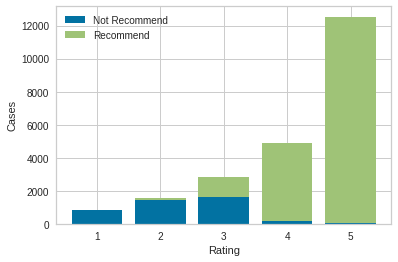

In [ ]:
#https://pythonguides.com/stacked-bar-chart-matplotlib/
plt.bar(Class, not_recommend, label='Not Recommend');
plt.bar(Class, recommend, bottom=not_recommend, label='Recommend');
plt.xlabel("Rating");
plt.ylabel("Cases");
plt.legend();

In [ ]:
rating_1= [df_yvalues.loc[(df_yvalues.recommended_ind == 1)&(df_yvalues.rating == 1),:].shape[0], 
             df_yvalues.loc[(df_yvalues.recommended_ind == 0)&(df_yvalues.rating == 1),:].shape[0]]
rating_2= [df_yvalues.loc[(df_yvalues.recommended_ind == 1)&(df_yvalues.rating == 2),:].shape[0], 
             df_yvalues.loc[(df_yvalues.recommended_ind == 0)&(df_yvalues.rating == 2),:].shape[0]]
rating_3= [df_yvalues.loc[(df_yvalues.recommended_ind == 1)&(df_yvalues.rating == 3),:].shape[0], 
             df_yvalues.loc[(df_yvalues.recommended_ind == 0)&(df_yvalues.rating == 3),:].shape[0]]
rating_4= [df_yvalues.loc[(df_yvalues.recommended_ind == 1)&(df_yvalues.rating == 4),:].shape[0], 
             df_yvalues.loc[(df_yvalues.recommended_ind == 0)&(df_yvalues.rating == 4),:].shape[0]]
rating_5= [df_yvalues.loc[(df_yvalues.recommended_ind == 1)&(df_yvalues.rating == 5),:].shape[0], 
             df_yvalues.loc[(df_yvalues.recommended_ind == 0)&(df_yvalues.rating == 5),:].shape[0]]
Class = ["Recommend", "Not Recommend"]


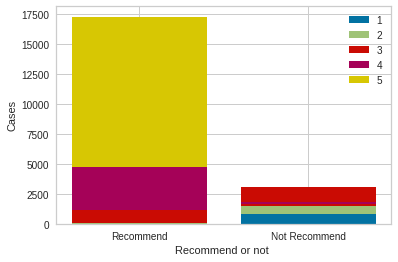

In [ ]:
#https://pythonguides.com/stacked-bar-chart-matplotlib/
plt.bar(Class, rating_1, label='1');
plt.bar(Class, rating_2, bottom=rating_1, label='2');
plt.bar(Class, rating_3, bottom=rating_2, label='3');
plt.bar(Class, rating_4, bottom=rating_3, label='4');
plt.bar(Class, rating_5, bottom=rating_4, label='5');
plt.xlabel("Recommend or not ");
plt.ylabel("Cases");
plt.legend();

In [ ]:
#Reason that the accuracy for recommend is more than rating: rec comes from people rate 2,3,4,5. Therefore, although the model tend to predict the rate to a higher level, it can 
#predict the rec more accurately because not only people rate 5 rec, but also who rate 2,3,4 also rec.

# Count Analysis

## Rating

In [ ]:
vectorizer_count = CountVectorizer(max_df=0.8, min_df=3)

X = df["review_text"]
y1 = df["rating"]
x_train_rating, x_test_rating, y_train_rating, y_test_rating = train_test_split(X,
                                                                                y1,
                                                                                test_size=0.2,
                                                                                stratify=y1, 
                                                                                random_state=123)
x_train_rating_count = vectorizer_count.fit_transform(x_train_rating)
x_test_rating_count = vectorizer_count.transform(x_test_rating)

In [ ]:
showDF = pd.DataFrame(x_train_rating_count.toarray(), columns = vectorizer_count.get_feature_names())
showA = showDF.sum()
showA.sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



dress      9059
fit        8023
size       7498
love       7175
top        6594
           ... 
starkly       3
starter       3
stash         3
staticy       3
lounger       3
Length: 5167, dtype: int64

### Logistics Regression

In [ ]:
lr_count = LogisticRegression(C=0.6, max_iter=1000, class_weight= "balanced", random_state=123)
lr_count.fit(x_train_rating_count, y_train_rating)

LogisticRegression(C=0.6, class_weight='balanced', max_iter=1000,
                   random_state=123)

In [ ]:
score = lr_count.score(x_test_rating_count, y_test_rating)
score

0.5789357474056083

In [ ]:
from sklearn.model_selection import GridSearchCV

lr_params = {
    'penalty': ['l1', 'l2'],        # l1 is Lasso, l2 is Ridge
    'solver': ['liblinear'],
    'C': [0.1,1,10,100]
}

lr_gscv = GridSearchCV(LogisticRegression(random_state=123), lr_params, cv=3, verbose=1)
lr_gscv.fit(x_train_rating_count, y_train_rating)
print(lr_gscv.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
lr_model = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', random_state=123).fit(x_train_rating_count, y_train_rating)

print(lr_model.score(x_train_rating_count, y_train_rating))
print(lr_model.score(x_test_rating_count, y_test_rating))

0.7159893992932862
0.6325899757120778


In [ ]:
print("The proportion of wrong predictions per rating:")
print(y_test_rating[y_test_rating != lr_model.predict(x_test_rating_count)].value_counts() / y_test_rating.value_counts())

The proportion of wrong predictions per rating:
1    0.890244
2    0.835484
3    0.667257
4    0.715886
5    0.071372
Name: rating, dtype: float64


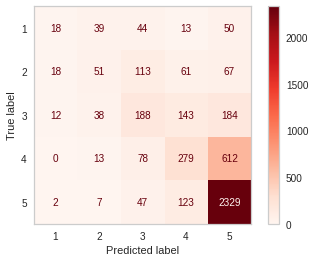

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

lr_cm = confusion_matrix(y_test_rating, lr_model.predict(x_test_rating_count))
lr_cmd = ConfusionMatrixDisplay(lr_cm, display_labels=['1','2','3','4','5'])
lr_cmd.plot(cmap = "Reds");
plt.grid(False)

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

nb = MultinomialNB()
nb.fit(x_train_rating_count, y_train_rating)
print(nb.score(x_train_rating_count, y_train_rating))
print(nb.score(x_test_rating_count, y_test_rating))

0.7249889575971732
0.623537204680945


In [ ]:
print("The proportion of wrong predictions per rating:")
print(y_test_rating[y_test_rating != nb.predict(x_test_rating_count)].value_counts() / y_test_rating.value_counts())

The proportion of wrong predictions per rating:
1    0.756098
2    0.783871
3    0.571681
4    0.605906
5    0.167464
Name: rating, dtype: float64


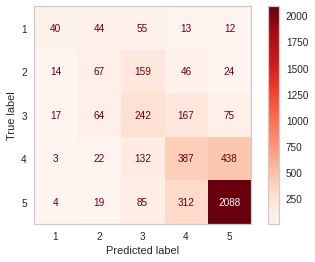

In [ ]:
nb_cm = confusion_matrix(y_test_rating, nb.predict(x_test_rating_count))
nb_cmd = ConfusionMatrixDisplay(nb_cm, display_labels=['1','2','3','4','5'])
nb_cmd.plot(cmap = "Reds");
plt.grid(False)

### Support Vector Machine

In [ ]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=0.01, class_weight="balanced", random_state=123)
svc.fit(x_train_rating_count, y_train_rating)

print(svc.score(x_train_rating_count, y_train_rating))
print(svc.score(x_test_rating_count, y_test_rating))

0.7415525618374559
0.6200044159858689


In [ ]:
print("The proportion of wrong predictions per rating:")
print(y_test_rating[y_test_rating != svc.predict(x_test_rating_count)].value_counts() / y_test_rating.value_counts())

The proportion of wrong predictions per rating:
1    0.621951
2    0.661290
3    0.647788
4    0.698574
5    0.144338
Name: rating, dtype: float64


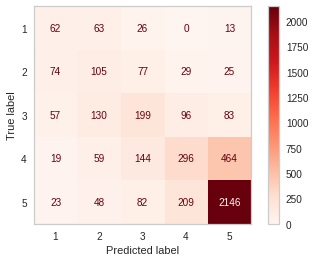

In [ ]:
svc_cm = confusion_matrix(y_test_rating, svc.predict(x_test_rating_count))
svc_cmd = ConfusionMatrixDisplay(svc_cm, display_labels=['1','2','3','4','5'])
svc_cmd.plot(cmap = "Reds");
plt.grid(False)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {'n_estimators':[i for i in range(10,30)],
             'max_depth':[i for i in range(3,10)]}

gscv_rf = GridSearchCV(RandomForestClassifier(random_state=91), param_grid=params_rf, cv=5, refit=True)
gscv_rf.fit(x_train_rating_count, y_train_rating)
print(gscv_rf.best_params_)

{'max_depth': 9, 'n_estimators': 11}


In [ ]:
rfc = RandomForestClassifier(max_depth=9, random_state=123, n_jobs=11, class_weight="balanced")
rfc.fit(x_train_rating_count, y_train_rating)

print(rfc.score(x_train_rating_count, y_train_rating))
print(rfc.score(x_test_rating_count, y_test_rating))

0.6634827738515902
0.5745197615367631


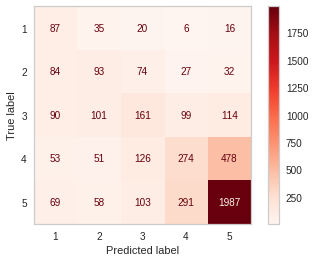

In [ ]:
rfc_cm = confusion_matrix(y_test_rating, rfc.predict(x_test_rating_count))
rfc_cmd = ConfusionMatrixDisplay(rfc_cm, display_labels=['1','2','3','4','5'])
rfc_cmd.plot(cmap = "Reds");
plt.grid(False)

## Recommendation

In [ ]:
vectorizer_count = CountVectorizer(max_df=0.8, min_df=3)

X = df["review_text"]
y2 = df["recommended_ind"]
# print(y2.value_counts())
x_train_rec, x_test_rec, y_train_rec, y_test_rec = train_test_split(X,
                                                                    y2,
                                                                    test_size=0.2,
                                                                    stratify=y2, 
                                                                    random_state=123)
x_train_rec_count = vectorizer_count.fit_transform(x_train_rec)
x_test_rec_count = vectorizer_count.transform(x_test_rec)

In [ ]:
showDF2 = pd.DataFrame(x_train_rec_count.toarray(), columns = vectorizer_count.get_feature_names())
showA2 = showDF2.sum()
showA2.sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



dress        9103
fit          8065
size         7398
love         7199
top          6647
             ... 
listing         3
listening       3
likewise        3
lifting         3
aa              3
Length: 5205, dtype: int64

### Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV

lr_gscv_rec = GridSearchCV(LogisticRegression(random_state=123), lr_params, cv=3, verbose=1)
lr_gscv_rec.fit(x_train_rec_count, y_train_rec)
print(lr_gscv_rec.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
lr_model_rec = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', random_state=123).fit(x_train_rec_count, y_train_rec)

print(lr_model_rec.score(x_train_rec_count, y_train_rec))
print(lr_model_rec.score(x_test_rec_count, y_test_rec))

0.913041077738516
0.8845219695296975


In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test_rec, lr_model_rec.predict(x_test_rec_count))

0.9311026215254907

In [ ]:
print(y_test_rec.value_counts())
print("\nThe proportion of wrong predictions per rating:")
print(y_test_rec[y_test_rec != lr_model_rec.predict(x_test_rec_count)].value_counts() / y_test_rec.value_counts())
print("\n42% of the 'not-recommended' is predicted as 'recommended'.")

1    3709
0     820
Name: recommended_ind, dtype: int64

The proportion of wrong predictions per rating:
0    0.424390
1    0.047183
Name: recommended_ind, dtype: float64

42% of the 'not-recommended' is predicted as 'recommended'.


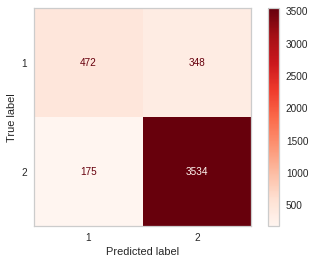

In [ ]:
lr_rec_cm = confusion_matrix(y_test_rec, lr_model_rec.predict(x_test_rec_count))
lr_rec_cmd = ConfusionMatrixDisplay(lr_rec_cm, display_labels=['1','2','3','4','5'])
lr_rec_cmd.plot(cmap = "Reds");
plt.grid(False)

## Naive Bayes

In [ ]:
nb_rec = MultinomialNB()
nb_rec.fit(x_train_rec_count, y_train_rec)
print(nb_rec.score(x_train_rec_count, y_train_rec))
print(nb_rec.score(x_test_rec_count, y_test_rec))

0.9033789752650176
0.87988518436741


In [ ]:
f1_score(y_test_rec, nb_rec.predict(x_test_rec_count))

0.9254590298711977

In [ ]:
print("The proportion of wrong predictions per rating:")
print(y_test_rec[y_test_rec != nb_rec.predict(x_test_rec_count)].value_counts() / y_test_rec.value_counts())

The proportion of wrong predictions per rating:
1    0.089512
0    0.258537
Name: recommended_ind, dtype: float64


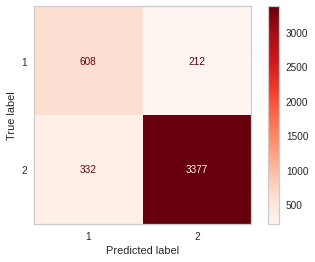

In [ ]:
nb_rec_cm = confusion_matrix(y_test_rec, nb_rec.predict(x_test_rec_count))
nb_rec_cmd = ConfusionMatrixDisplay(nb_rec_cm, display_labels=['1','2','3','4','5'])
nb_rec_cmd.plot(cmap = "Reds");
plt.grid(False)

### Support Vector Machine

In [ ]:
svc_rec = LinearSVC(C=0.01, class_weight="balanced", random_state=123)
svc_rec.fit(x_train_rec_count, y_train_rec)
print(svc_rec.score(x_train_rec_count, y_train_rec))
print(svc_rec.score(x_test_rec_count, y_test_rec))

0.8968087455830389
0.8578052550231839


In [ ]:
f1_score(y_test_rec, svc_rec.predict(x_test_rec_count))

0.9087301587301588

In [ ]:
print("The proportion of wrong predictions per rating:")
print(y_test_rec[y_test_rec != svc_rec.predict(x_test_rec_count)].value_counts() / y_test_rec.value_counts())

The proportion of wrong predictions per rating:
1    0.135616
0    0.171951
Name: recommended_ind, dtype: float64


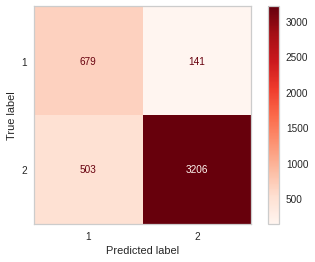

In [ ]:
svc_rec_cm = confusion_matrix(y_test_rec, svc_rec.predict(x_test_rec_count))
svc_rec_cmd = ConfusionMatrixDisplay(svc_rec_cm, display_labels=['1','2','3','4','5'])
svc_rec_cmd.plot(cmap = "Reds");
plt.grid(False)

### Random Forest

In [ ]:
gscv_rf2 = GridSearchCV(RandomForestClassifier(random_state=91), param_grid=params_rf, cv=5, refit=True)
gscv_rf2.fit(x_train_rec_count, y_train_rec)
print(gscv_rf2.best_params_)

{'max_depth': 6, 'n_estimators': 11}


In [ ]:
rfc_rec = RandomForestClassifier(max_depth=6, random_state=123, n_jobs=11, class_weight="balanced")
rfc_rec.fit(x_train_rec_count, y_train_rec)

print(rfc_rec.score(x_train_rec_count, y_train_rec))
print(rfc_rec.score(x_test_rec_count, y_test_rec))

0.8527495583038869
0.8335173327445352


In [ ]:
f1_score(y_test_rec, rfc_rec.predict(x_test_rec_count))

0.8923472301541976

In [ ]:
print("The proportion of wrong predictions per rating:")
print(y_test_rec[y_test_rec != rfc_rec.predict(x_test_rec_count)].value_counts() / y_test_rec.value_counts())

The proportion of wrong predictions per rating:
1    0.157455
0    0.207317
Name: recommended_ind, dtype: float64


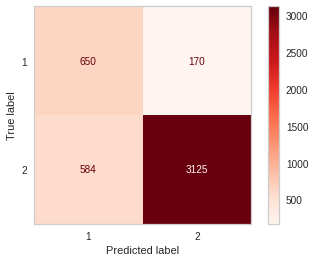

In [ ]:
rf_rec_cm = confusion_matrix(y_test_rec, rfc_rec.predict(x_test_rec_count))
rf_rec_cmd = ConfusionMatrixDisplay(rf_rec_cm, display_labels=['1','2','3','4','5'])
rf_rec_cmd.plot(cmap = "Reds");
plt.grid(False)

### Evaluation

In [ ]:
model_evaluation = np.array([['Logistic Regression', 'Naive Bayes', 'Support Vector Machine', 'Random Forest'], 
                             [0.8845, 0.8799, 0.8578, 0.8335],
                             [0.9311, 0.9255, 0.9087, 0.8923],
                             [0.42, 0.26, 0.17, 0.21]])

evaluation_df = pd.DataFrame(data = model_evaluation.T, columns = ['Models', 'Accuracy', 'F1 scores', '% of wrong predicted not-recommend'])
evaluation_df.sort_values(by = 'F1 scores', ascending = False)
evaluation_df

,Models,Accuracy,F1 scores,% of wrong predicted not-recommend
0,Logistic Regression,0.8845,0.9311,0.42
1,Naive Bayes,0.8799,0.9255,0.26
2,Support Vector Machine,0.8578,0.9087,0.17
3,Random Forest,0.8335,0.8923,0.21
